# Monthly OMI NO2 time series using rioxarray and stackstac {.unnumbered}

This notebook demonstrates how to generate a timeseries via `rioxarray`, `satsarch` and `stackstac`.

* Author: Aimee Barciauskas
* Lasted Updated Date: May 13, 2022

In [19]:
import rioxarray
import stackstac
from satsearch import Search

Note: If you wish to run this code outside of AWS sagemaker, you will need to request access via an AWS IAM role or user permission. Please email aimee@developmentseed.org if you are interested in being provided read access to the data outside of our sagemker instance.

In [20]:
# Skip this if running in AWS Sagemaker
%run -i 'create_rio_session.py'

## Use satsearch to discover items in the no2-monthly collection for China

In [21]:
stac_api_url = 'https://staging-stac.delta-backend.xyz/'
china_bbox = [
    73.675,
    18.198,
    135.026,
    53.459
]
datetime = "2000-01-01T00:00:00Z/2022-01-02T00:00:00Z"
collection = 'no2-monthly'

search = Search.search(
    url=stac_api_url,
    bbox=china_bbox,
    datetime=datetime,
    collections=[collection],
    limit=1000
)
items = search.items()

url is https://staging-stac.delta-backend.xyz/search
headers is None
kwargs is {'limit': 1000, 'bbox': [73.675, 18.198, 135.026, 53.459], 'datetime': '2000-01-01T00:00:00Z/2022-01-02T00:00:00Z', 'collections': ['no2-monthly']}


In [22]:
len(items)

73

## Create an `xarray.DataArray` using `stackstac`

In [36]:
stack = stackstac.stack(items)
stack = stack.assign_coords({"time": stack.start_datetime})
stack

,Array,Chunk
Bytes,3.52 GiB,8.00 MiB
Shape,"(73, 1, 1800, 3600)","(1, 1, 1024, 1024)"
Count,738 Tasks,584 Chunks
Type,float64,numpy.ndarray


## Clip the data to the bounding box for China

In [37]:
# Subset to Bounding Box for China
subset = stack.rio.clip_box(
    minx=china_bbox[0],
    miny=china_bbox[1],
    maxx=china_bbox[2],
    maxy=china_bbox[3]
)
subset

,Array,Chunk
Bytes,121.06 MiB,1.44 MiB
Shape,"(73, 1, 354, 614)","(1, 1, 354, 535)"
Count,884 Tasks,146 Chunks
Type,float64,numpy.ndarray


## Select a band of data

There is just one band in this case, `cog_default`.

In [38]:
# select the band default
data_band = subset.sel(band='cog_default')
data_band

<xarray.DataArray 'stackstac-5227002b71043bbfd9046c1aa79faf1f' (time: 73,
                                                                y: 354, x: 614)>
dask.array<getitem, shape=(73, 354, 614), dtype=float64, chunksize=(1, 354, 535), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time            (time) <U20 '2022-01-01T00:00:00Z' ... '2016-01-01T00:00:...
    id              (time) <U45 'OMI_trno2_monthly_0.10x0.10_202201_Col3_V4.n...
    band            <U11 'cog_default'
  * x               (x) float64 73.7 73.8 73.9 74.0 ... 134.7 134.8 134.9 135.0
  * y               (y) float64 53.5 53.4 53.3 53.2 53.1 ... 18.5 18.4 18.3 18.2
    proj:shape      object {1800, 3600}
    ...              ...
    start_datetime  (time) <U20 '2022-01-01T00:00:00Z' ... '2016-01-01T00:00:...
    end_datetime    (time) <U20 '2022-01-31T00:00:00Z' ... '2016-01-31T00:00:...
    proj:epsg       int64 4326
    proj:transform  object {0.1, 0.0, 1.0, -0.1, -180.0, 90.0}
    epsg            int64 4326
    spatial_ref     int64 0
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-180.0, -90.0, 180.0, 90.0), r...
    resolution:  0.1

In [39]:
# Group data into months
dates = data_band.groupby('time')

In [40]:
# Average over entire spatial bounding box for each month
means = dates.mean(dim=('x', 'y'))

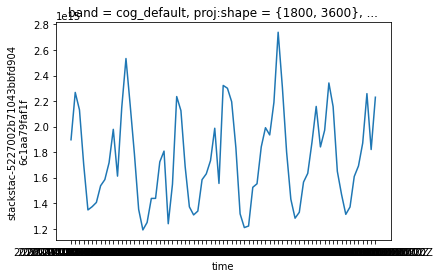

In [41]:
means.plot()